In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The network will be broken down into a series of tasks from **loading in data to defining and training adversarial networks.** At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the images that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is shown below.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/raw/3a95d118f9df5a86826e1791c5c100817f0fd924/project-face-generation/assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [2]:
# Can comment out after executing
#!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip
#!unzip processed-celeba-small.zip
#!wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/project-face-generation/problem_unittests.py

In [3]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that there are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_images) each.

### Pre-process and Load the Data

Since the project's main focus is on building GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### **Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:**
* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder
To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [5]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [22]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x,y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """

    # TODO: Implement function and return a DataLoader

    # Define transforms to Resize to `image_size` and convert to Torch Tensor
    transform = transforms.Compose([
                        transforms.Resize(image_size),
                        transforms.ToTensor()])
    
    # Create dataset using `.ImageFolder`
    celeba_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

    # Create DataLoader from `celeba_dataset`
    celeba_dl = torch.utils.data.DataLoader(dataset=celeba_dataset, 
                                            batch_size=batch_size)    

    return celeba_dl

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images.

* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** 32. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!



In [23]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, you can view some images! You should see square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions correctly to display an image, suggested `imshow` code is below, but it may not be perfect.

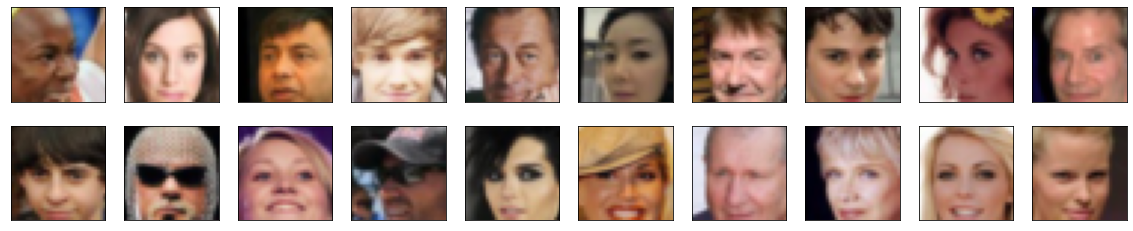

In [24]:
# helper display functio
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20,4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0 to 1).

In [26]:
## TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
        with a feature_range of pixel values from -1 to 1.
        This function assumes that the input x is already scaled from 0-1.'''
    # assume x is saled to (0, 1)
    # scale to feature_range and return scaled x

    scaled_x = (feature_range[1] - feature_range[0])*x + feature_range[0]

    return scaled_x

In [27]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9529)
Max:  tensor(0.9451)


---
# Define the Model
A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator
Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake

In [28]:
import torch.nn as nn
import torch.nn.functional as F

In [30]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, 
         batch_norm=True):
    """ Creates a convolutional layer, with optional batch normalization """

    layers = []

    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, 
                           padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(num_features=out_channels))

    return nn.Sequential(*layers)

In [33]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim

        # complete init function
        self.conv1 = conv(in_channels=3, out_channels=conv_dim, kernel_size=4,
                          batch_norm=False)
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim*2, 
                          kernel_size=4)
        self.conv3 = conv(in_channels=conv_dim*2, out_channels=conv_dim*4,
                          kernel_size=4)
        self.conv4 = conv(in_channels=conv_dim*4, out_channels=conv_dim*8, 
                          kernel_size=4)
        self.conv5 = conv(in_channels=conv_dim*8, out_channels=conv_dim*16, 
                          kernel_size=4)
        
        self.dropout = nn.Dropout(p=0.3)
        
        # Flattened vector has size: conv_dim*16 x 1 x 1
        self.fc1 = nn.Linear(in_features=conv_dim*16*1*1, 
                             out_features=conv_dim*8)
        self.fc2 = nn.Linear(in_features=conv_dim*8, out_features=conv_dim*4)
        self.fc3 = nn.Linear(in_features=conv_dim*4, out_features=conv_dim)
        self.fc4 = nn.Linear(in_features=conv_dim, out_features=1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: Discriminator logits; the output of the neural network
        """
        # define the feedforward behavior

        # pass through convolutional layers (with optional batchnorm and 
        # Leaky ReLU)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = F.leaky_relu(self.conv5(x), 0.2)

        # Flatten x into a vector for linear layers
        x = x.view(-1, self.conv_dim*16*1*1) # (batch_size, conv_dim*16)

        # pass through linear layers
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x) # no sigmoid activation on last layer
        return x

"""
DON"T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be an image of shape `32x32x3`

In [41]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1,
           batch_norm=True):
    """ Create a transposed-convolutional layer, with optional batch 
    normalization. """

    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers

    layers = []

    t_conv = nn.ConvTranspose2d(in_channels=in_channels, 
        out_channels=out_channels, kernel_size=kernel_size, stride=stride, 
        padding=padding, bias=False)
    
    layers.append(t_conv)

    if batch_norm:
        layers.append(nn.BatchNorm2d(num_features=out_channels))

    return nn.Sequential(*layers)

In [44]:
class Generator(nn.Module):

    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose
            convolutional layer
        """
        super(Generator, self).__init__()
        self.z_size = z_size
        self.conv_dim = conv_dim

        # complete init function

        # Linear layers. Started with z_size -> conv_dim*4 so that each
        # linear layer can go to an increasing number of out_features.
        # This assumes that z_size = 100 < (conv_dim=32)*4 = 128
        self.fc1 = nn.Linear(in_features=z_size, out_features=conv_dim*4)
        self.fc2 = nn.Linear(in_features=conv_dim*4, out_features=conv_dim*8)
        self.fc3 = nn.Linear(in_features=conv_dim*8, out_features=conv_dim*16)

        self.dropout = nn.Dropout(p=0.3)

        self.t_conv1 = deconv(in_channels=conv_dim*16*1*1, 
                              out_channels=conv_dim*8, kernel_size=4)
        self.t_conv2 = deconv(in_channels=conv_dim*8, out_channels=conv_dim*4,
                              kernel_size=4)
        self.t_conv3 = deconv(in_channels=conv_dim*4, out_channels=conv_dim*2,
                              kernel_size=4)
        self.t_conv4 = deconv(in_channels=conv_dim*2, out_channels=conv_dim,
                              kernel_size=4)
        self.t_conv5 = deconv(in_channels=conv_dim, out_channels=3, 
                              kernel_size=4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior

        x = torch.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        # reshape x for convolutional layers
        # (batch_size, depth=conv_dim*16,1,1)
        x = x.view(-1, self.conv_dim*16, 1, 1) 

        # transpose convolutional layers
        x = torch.relu(self.t_conv1(x))
        x = torch.relu(self.t_conv2(x))
        x = torch.relu(self.t_conv3(x))
        x = torch.relu(self.t_conv4(x))
        x = torch.tanh(self.t_conv5(x))

        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed
